# Exploratory data analysis

I explore patterns in the cleaned dataset. The notebook covers overall production trends, crop-wise comparisons, distribution analysis, outliers, and simple correlations. Each figure includes a short interpretation written in first-person.

In [25]:
# Imports and load cleaned data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_style('whitegrid')
out_path = Path('..') / 'data' / 'processed' / 'cleaned_agriculture_data.csv'
df = pd.read_csv(out_path)
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   crop    127 non-null    object 
 1   year    127 non-null    Int64  
 2   metric  127 non-null    object 
 3   value   127 non-null    float64
dtypes: Int64(1), float64(1), object(2)
memory usage: 4.2+ KB


## Overall production trends

I aggregate production across all crops to see the general trend by year.

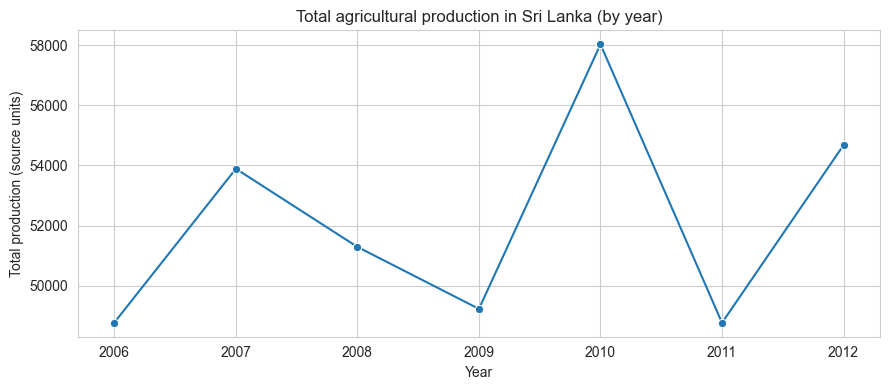

In [27]:
prod = df[df['metric'] == 'production'].copy()
prod_group = prod.groupby('year', as_index=False)['value'].sum().dropna()
plt.figure(figsize=(9,4))
sns.lineplot(data=prod_group, x='year', y='value', marker='o')
plt.title('Total agricultural production in Sri Lanka (by year)')
plt.xlabel('Year')
plt.ylabel('Total production (source units)')
plt.xticks(prod_group['year'].dropna().astype(int).unique())
plt.tight_layout()
plt.show()

**Interpretation**

I check whether total production rises or falls and note any years with clear changes.

## Crop-wise comparison

I plot time series for the top crops by total production to compare their trajectories.

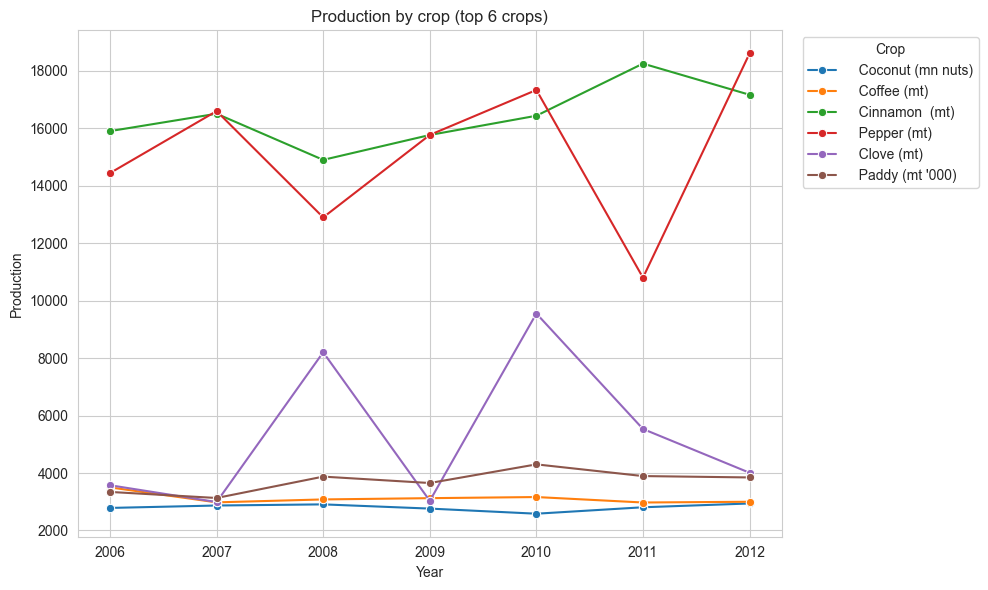

In [15]:
top_crops = prod.groupby('crop', as_index=False)['value'].sum().nlargest(6, 'value')['crop'].tolist()
prod_top = prod[prod['crop'].isin(top_crops)].copy()
plt.figure(figsize=(10,6))
sns.lineplot(data=prod_top, x='year', y='value', hue='crop', marker='o')
plt.title('Production by crop (top 6 crops)')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend(title='Crop', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation**

I identify which crops contribute most and whether their trends align or diverge.

## Distribution analysis

I inspect the distribution of production values and show per-crop boxplots for variability.

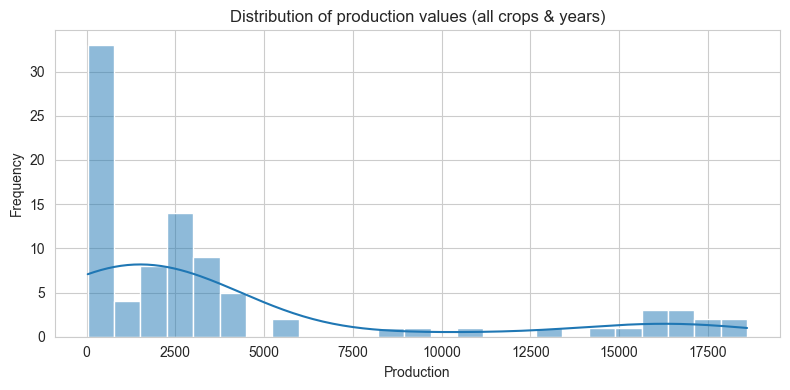

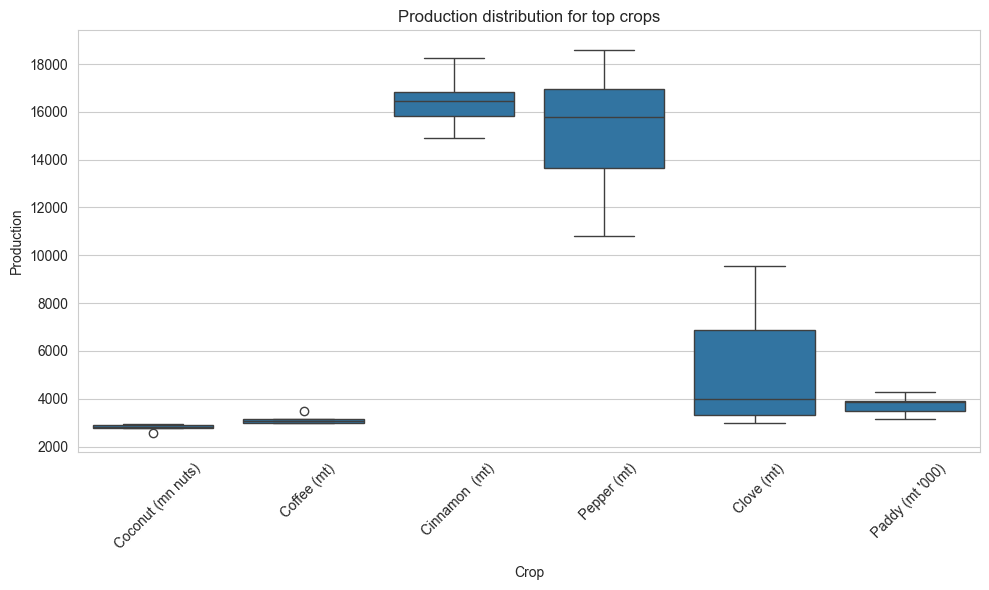

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(prod['value'].dropna(), bins=25, kde=True)
plt.title('Distribution of production values (all crops & years)')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
sns.boxplot(data=prod_top, x='crop', y='value')
plt.title('Production distribution for top crops')
plt.xlabel('Crop')
plt.ylabel('Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**

The histogram shows skew and tail behaviour; the boxplots highlight which crops are more variable or have extreme values.

## Outliers

I flag potential outliers using z-scores within each crop and list the most extreme cases.

In [17]:
prod = prod.copy()
prod['zscore_within_crop'] = prod.groupby('crop')['value'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
outliers = prod[prod['zscore_within_crop'].abs() > 2].sort_values('zscore_within_crop', key=lambda s: s.abs(), ascending=False)
outliers[['crop','year','value','zscore_within_crop']].head(15)

,crop,year,value,zscore_within_crop
22,Nutmeg and Mace (mt),2007,5553.0,2.419704
30,Cocoa (mt),2008,1695.0,2.348157
12,Sugar Production (by Year) (mt '000),2006,56.0,2.276753
3,Coffee (mt),2006,3500.0,2.243281
54,Coconut (mn nuts),2010,2584.0,-2.044106


**Interpretation**

I check the flagged rows to decide if they are data errors or real events. I would fix errors before modeling.

## Correlation (production vs exports)

I pivot metrics to compare available numeric metrics (production, volume, value) and display a correlation matrix.

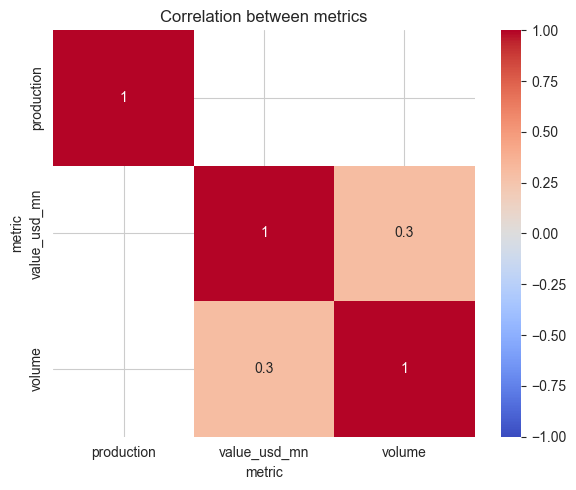

In [18]:
wide = df.pivot_table(index=['crop','year'], columns='metric', values='value')
numeric_metrics = [c for c in wide.columns.tolist() if pd.api.types.is_numeric_dtype(wide[c])]
corr = wide[numeric_metrics].corr() if numeric_metrics else pd.DataFrame()
plt.figure(figsize=(6,5))
if not corr.empty:
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between metrics')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric metric columns to compute correlations.')

**Interpretation**

I look for strong correlations but remember correlation does not imply causation. Further analysis would be needed to investigate links.

## Additional plots

Extra plots for deeper pattern discovery: share by crop, year-over-year change, rolling averages, production vs export scatter (if available), violin plots, and pairwise relationships.

<Figure size 1000x500 with 0 Axes>

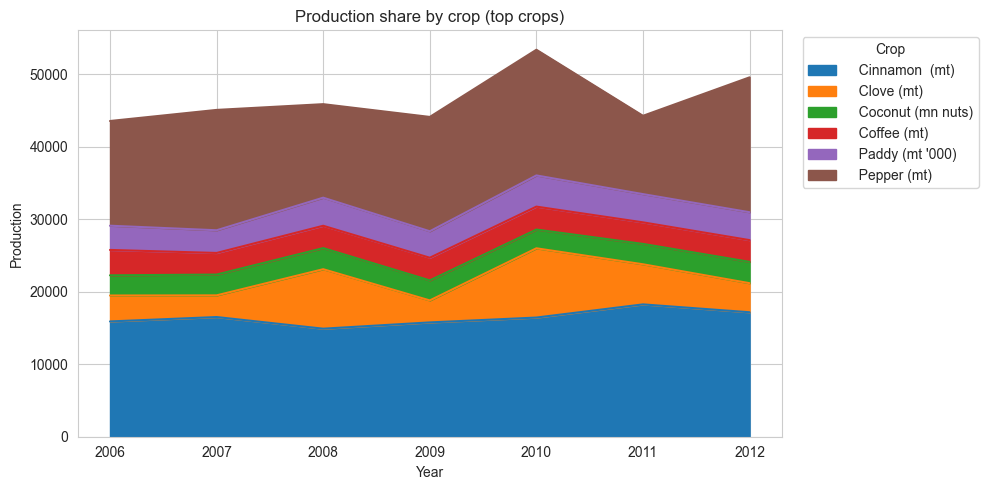

In [19]:
# Production share by crop (stacked area for top crops)
share_df = prod[prod['crop'].isin(top_crops)].pivot_table(index='year', columns='crop', values='value', aggfunc='sum').fillna(0)
plt.figure(figsize=(10,5))
share_df.plot.area(figsize=(10,5))
plt.title('Production share by crop (top crops)')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend(title='Crop', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation**

The stacked area plot shows changes in composition of total production and highlights which crops dominate each year.

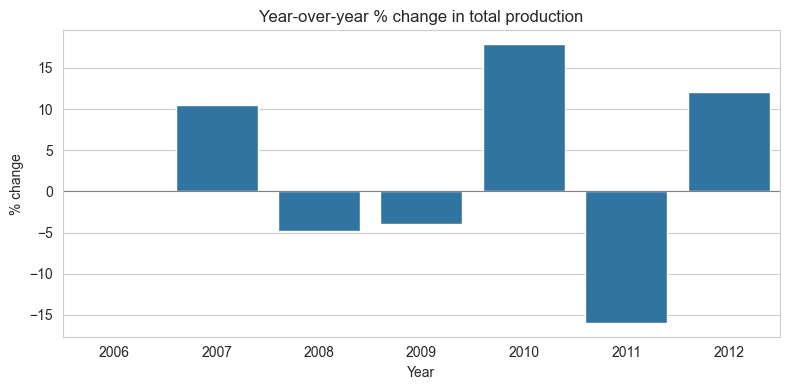

In [20]:
# Year-over-year percent change for total production
prod_group = prod.groupby('year', as_index=False)['value'].sum().dropna()
prod_group['pct_change'] = prod_group['value'].pct_change() * 100
plt.figure(figsize=(8,4))
sns.barplot(data=prod_group, x='year', y='pct_change', color='tab:blue')
plt.title('Year-over-year % change in total production')
plt.xlabel('Year')
plt.ylabel('% change')
plt.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

**Interpretation**

This bar chart highlights years with strong growth or decline in aggregate production and helps spot abrupt changes for follow-up.

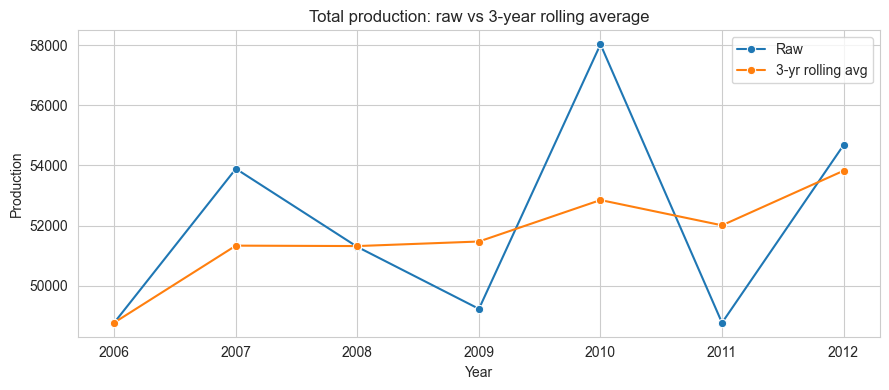

In [21]:
# Rolling average (3-year) of total production
prod_group['rolling_3yr'] = prod_group['value'].rolling(3, min_periods=1).mean()
plt.figure(figsize=(9,4))
sns.lineplot(data=prod_group, x='year', y='value', marker='o', label='Raw')
sns.lineplot(data=prod_group, x='year', y='rolling_3yr', marker='o', label='3-yr rolling avg')
plt.title('Total production: raw vs 3-year rolling average')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation**

The rolling average smooths short-term fluctuations to reveal underlying trends; useful to check if changes are persistent.

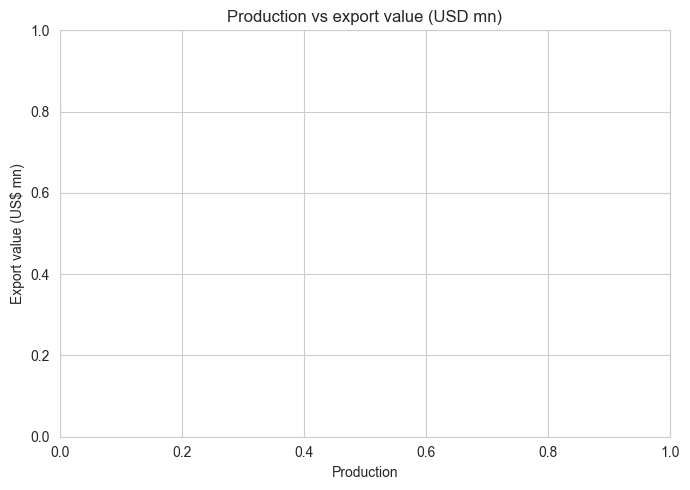

In [22]:
# Production vs export value scatter (if available)
try:
    if 'value_usd_mn' in wide.columns and 'production' in wide.columns:
        merged = wide.reset_index()[['crop','year','production','value_usd_mn']].dropna()
        plt.figure(figsize=(7,5))
        sns.scatterplot(data=merged, x='production', y='value_usd_mn', hue='crop')
        plt.title('Production vs export value (USD mn)')
        plt.xlabel('Production')
        plt.ylabel('Export value (US$ mn)')
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        plt.show()
    else:
        print('Export value or production columns not available together for scatter plot.')
except Exception as e:
    print('Could not create scatter plot:', e)

**Interpretation**

A positive relationship would suggest larger production associates with larger export value; lack of relationship suggests local consumption or other factors.

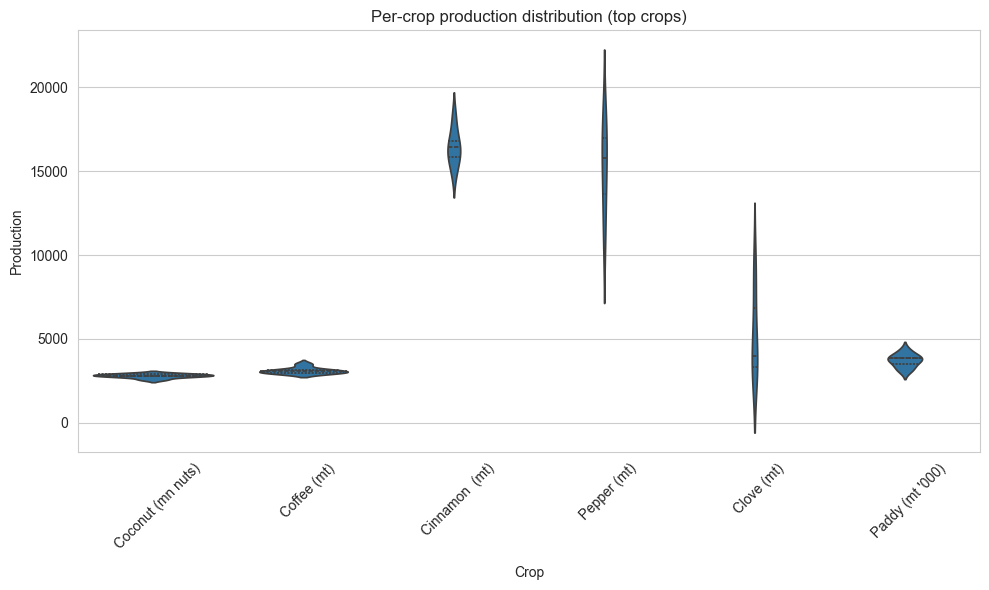

In [23]:
# Violin plot for per-crop distribution (top crops)
plt.figure(figsize=(10,6))
sns.violinplot(data=prod_top, x='crop', y='value', inner='quartile')
plt.title('Per-crop production distribution (top crops)')
plt.xlabel('Crop')
plt.ylabel('Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**

Violin plots show the full distribution per crop; wide violins indicate large variability and can point to unstable production patterns.